In [56]:
import time
import elfi
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

%matplotlib inline
%precision 2

# Set an arbitrary seed and a global random state to keep the randomly generated quantities the same between runs
seed = 20170530  # this will be separately given to ELFI
np.random.seed(seed)

In [57]:
how_huge_dataset = 100
x = range(how_huge_dataset)
#Defining training set
train = x[33:66]
train = np.array(train).reshape((1, len(train)))

### Inference with ELFI: case MA(2) model 2nd order moving average model MA(2) as an example. MA(2) is a common model used in univariate time series analysis.

In [66]:
def MA2(t1, t2, n_obs=100, batch_size=1, random_state=None):
    # Make inputs 2d arrays for numpy broadcasting with w
    t1 = np.asanyarray(t1).reshape((-1, 1))
    t2 = np.asanyarray(t2).reshape((-1, 1))
    random_state = random_state or np.random

    w = random_state.randn(batch_size, n_obs+2)  # i.i.d. sequence ~ N(0,1)
    x = w[:, 2:] + t1*w[:, 1:-1] + t2*w[:, :-2]
    return x
#Function needed to plot and to compare observation data with simulated data
def plot_MA2(t1, t2, data):
    t1 = np.asanyarray(t1).reshape((-1, 1))
    t2 = np.asanyarray(t2).reshape((-1, 1))
    
    w = random_state.randn(batch_size, n_obs+2)  # i.i.d. sequence ~ N(0,1)
    x = w[:, 2:] + t1*w[:, 1:-1] + t2*w[:, :-2]
    
    return x

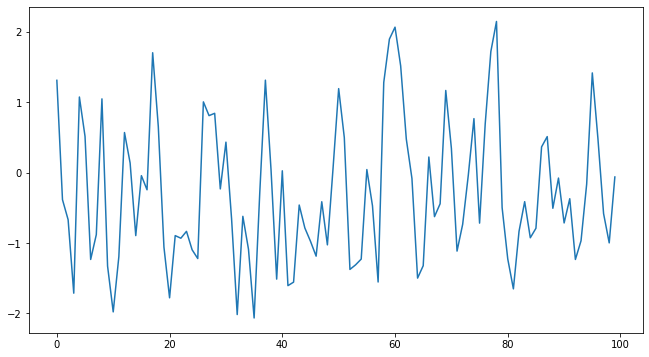

In [67]:
# true parameters
t1_true = 0.6
t2_true = 0.2

y_obs = MA2(t1_true, t2_true)
#Training set
y_obs2 = MA2(t1_true, t2_true,n_obs=33)
# Plot the observed sequence
plt.figure(figsize=(11, 6));
plt.plot(y_obs.ravel());

In [68]:
# a node is defined by giving a distribution from scipy.stats together with any arguments (here 0 and 2)
t1_param = elfi.Prior(scipy.stats.uniform, 0, 2)

# ELFI also supports giving the scipy.stats distributions as strings
t2_param = elfi.Prior('uniform', 0, 2)

In [69]:
Y = elfi.Simulator(MA2, t1_param, t2_param, observed=y_obs2)

In [70]:
def autocov(x, lag=1):
    C = np.mean(x[:,lag:] * x[:,:-lag], axis=1)
    return C

In [71]:
#Summary node is defined by giving the autocovariance function and the simulated data (also includes observed data)
S1 = elfi.Summary(autocov, Y)
S2 = elfi.Summary(autocov, Y, 2)
#Calculating the squared distance (S1_sim-S1_obs)**2 + (S2_sim-S2_obs)**2
d = elfi.Distance('euclidean', S1, S2)
#Inference with rejection sampling
rej = elfi.Rejection(d, batch_size=10000, seed=seed)
N = 1000
%time result = rej.sample(N, quantile=0.001)
#Print sampled means of parameters
print(result)

Progress: |██████████████████████████████████████████████████| 100.0% Complete
Wall time: 8.36 s
Method: Rejection
Number of samples: 1000
Number of simulations: 1000000
Threshold: 0.0409
Sample means: _prior_1457: 1, _prior_22c1: 0.981, _prior_2d5c: 0.991, _prior_3bd3: 0.993, _prior_3df5: 1.04, _prior_4c8f: 0.653, _prior_51cd: 0.974, _prior_7e31: 1.03, _prior_a390: 0.984, _prior_b55e: 1.03, _prior_d3a9: 0.978, _prior_d49f: 0.729, _prior_f585: 1.01, _prior_f5f9: 1.01, t1_param: 0.991, t2_param: 0.989



In [72]:
#Final result of mean samples
t1_result_last = result.samples['t1_param'].mean()
t2_result_last = result.samples['t2_param'].mean()
#Created simulated model from mean samples
sim_data=MA2(t1_result_last, t2_result_last)

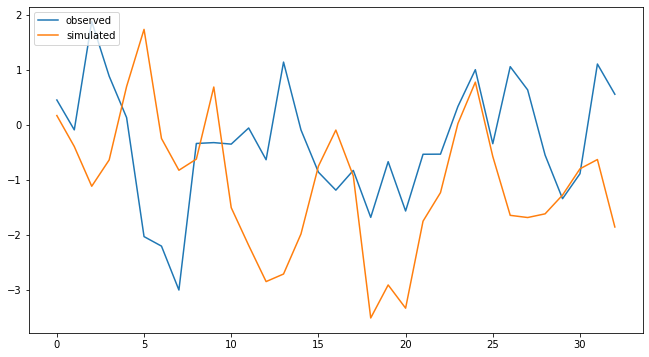

In [65]:
#Comparing observed data with simulated data on posterior parmeters (on whole data set)
plt.figure(figsize=(11, 6));
plt.plot(y_obs.ravel(),label="observed");
plt.plot(sim_data.ravel(),label="simulated");
plt.legend(loc="upper left")
plt.show()